In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

In [ ]:
!unzip PennFudanPed.zip

In [ ]:
import torchvision
torchvision.__version__

'0.15.2+cu118'

## Dataset

In [6]:
import os
import numpy as np
import torch
from PIL import Image


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]

        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.nonzero(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

## 1 - Finetuning on Classifier

In [7]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 288MB/s]


### 2 - Modifying the model to add a different backbone



In [8]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 38.8MB/s]


In [9]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

mount root dir

In [4]:
from google.colab import drive
drive.mount('/content/drive')

import os
path = "/content/drive/MyDrive/Colab Notebooks"
os.chdir(path)
cwd= os.getcwd()
print (cwd)

/content/drive/MyDrive/Colab Notebooks


get helper functions(in pytorch/vision/detection)

In [ ]:
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

In [13]:

# Since v0.15.0 torchvision provides `new Transforms API <https://pytorch.org/vision/stable/transforms.html>`_
# to easily write data augmentation pipelines for Object Detection and Segmentation tasks.
#
# Let’s write some helper functions for data augmentation /
# transformation:

import transforms as T

def get_transform(train):
    transforms = []
    transforms.append(T.PILToTensor())
    transforms.append(T.ToDtype(torch.float))
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)


# Testing ``forward()`` method (Optional)
# ---------------------------------------
#
# Before iterating over the dataset, it's good to see what the model
# expects during training and inference time on sample data.
import utils


model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    num_workers=4,
    collate_fn=utils.collate_fn
)

# For Training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # Returns losses and detections
print(output)

# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # Returns predictions
print(predictions[0])

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


{'loss_classifier': tensor(15.9107, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(2.4906, grad_fn=<DivBackward0>), 'loss_objectness': tensor(61.5529, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.6565, grad_fn=<DivBackward0>)}
{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


Let’s now write the main function which performs the training and the
validation:



In [23]:
from engine import train_one_epoch, evaluate

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    collate_fn=utils.collate_fn
)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(
    params,
    lr=0.0001,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

# let's train it for 5 epochs
num_epochs = 5

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    # evaluate(model, data_loader_test, device=device)

print("That's it!")

Epoch: [0]  [ 0/60]  eta: 0:00:42  lr: 0.000002  loss: 274.4883 (274.4883)  loss_classifier: 18.9765 (18.9765)  loss_box_reg: 2.5631 (2.5631)  loss_mask: 242.5698 (242.5698)  loss_objectness: 9.4135 (9.4135)  loss_rpn_box_reg: 0.9653 (0.9653)  time: 0.7110  data: 0.0677  max mem: 11961
Epoch: [0]  [10/60]  eta: 0:00:30  lr: 0.000019  loss: 48.1229 (86.6592)  loss_classifier: 1.7162 (4.8601)  loss_box_reg: 1.0894 (1.2540)  loss_mask: 40.7055 (76.4905)  loss_objectness: 1.2638 (3.0310)  loss_rpn_box_reg: 1.1888 (1.0236)  time: 0.6075  data: 0.0462  max mem: 12296
Epoch: [0]  [20/60]  eta: 0:00:23  lr: 0.000036  loss: 19.6454 (53.8014)  loss_classifier: 1.3381 (3.3555)  loss_box_reg: 0.5847 (0.8571)  loss_mask: 9.5480 (41.9210)  loss_objectness: 1.2053 (6.6557)  loss_rpn_box_reg: 0.5936 (1.0121)  time: 0.5689  data: 0.0374  max mem: 12296
Epoch: [0]  [30/60]  eta: 0:00:17  lr: 0.000053  loss: 4.6187 (39.2501)  loss_classifier: 0.8854 (2.6812)  loss_box_reg: 0.2621 (0.6601)  loss_mask: 1.0

tensor([0.4938, 0.4640, 0.4259, 0.4100, 0.3986, 0.3939, 0.3760, 0.3725, 0.3699,
        0.3698, 0.3485, 0.3465, 0.3458, 0.3401, 0.3362, 0.3331, 0.3331, 0.3315,
        0.3150, 0.3149, 0.3110, 0.3073, 0.3047, 0.3006, 0.2999, 0.2852, 0.2818,
        0.2639, 0.2591, 0.2584, 0.2524, 0.2465, 0.2462, 0.2461, 0.2394, 0.2384,
        0.2373, 0.2365, 0.2268, 0.2191, 0.2175, 0.2112, 0.2082, 0.1981, 0.1659,
        0.1644, 0.1641, 0.1504, 0.1462, 0.1460, 0.1445, 0.1425, 0.1342, 0.1341,
        0.1331, 0.1297, 0.1295, 0.1098, 0.1052, 0.0989, 0.0923, 0.0896, 0.0867,
        0.0644, 0.0613, 0.0589, 0.0573], device='cuda:0')


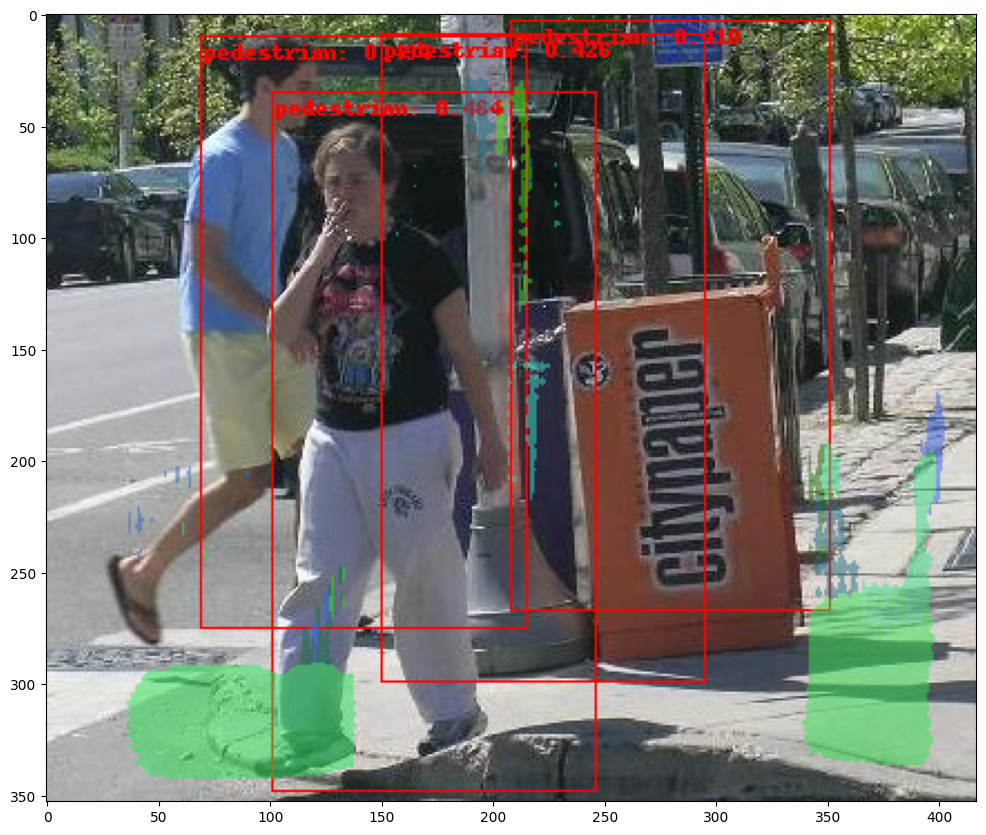

In [56]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
from PIL import Image
from torchvision.io import read_image

# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
image = Image.open(r"PennFudanPed/PNGImages/PennPed00055.png").convert("RGB")
eval_transform = get_transform(train=False)

model.to(device)
model.eval()
with torch.no_grad():
    target = {}
    x, _ = eval_transform(image, target)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]

image = torchvision.transforms.ToTensor()(image)
image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
pred_boxes_ = pred["boxes"]
pred_labels_ = pred["labels"]
pred_scores = pred["scores"]
pred_boxes = []
pred_labels = []
for i, box in enumerate(pred_boxes_):
    if pred_scores[i] > 0.4:
        pred_boxes.append(box.tolist())
        pred_labels.append(f"pedestrian: {pred_scores[i]:.3f}")

pred_boxes = torch.tensor(pred_boxes)
print(pred_scores)
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

# print(pred["scores"].shape)
# print(pred["boxes"])
# print(pred["masks"])
masks = (pred["masks"] > 0.8).squeeze(1)
# print(masks)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5)

plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))